In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import torch

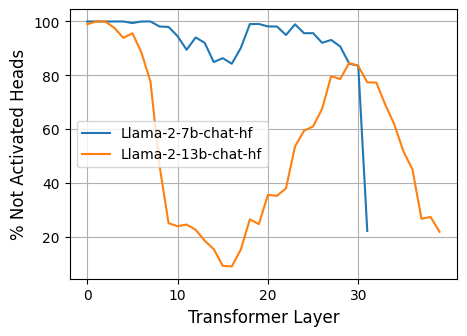

In [8]:
# Plot sparsity
prof_dir = "profile_results"
attn_threshold = 1.0
mlp_threshold = 1.0

# Define subplots
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
for model_name in ["Llama-2-7b-chat-hf", "Llama-2-13b-chat-hf"]:
    layer_norms = json.load(open(f"{prof_dir}/{model_name}/layerwise_norms.json", "r"))

    layers, attn_sparsities = [], []
    for layer, sparsity_dict in layer_norms.items():
        attn_sparsity = sparsity_dict["attn_sparsity"][str(attn_threshold)]
        layers.append(layer)
        attn_sparsities.append(attn_sparsity * 100)
    
    ax.plot(layers, attn_sparsities, label=model_name)
ax.set_xticks(np.arange(0, len(layers), 10))
ax.set_xlabel("Transformer Layer", fontsize=12)
ax.set_ylabel("% Not Activated Heads", fontsize=12)
ax.legend()
ax.grid(True)
plt.show()

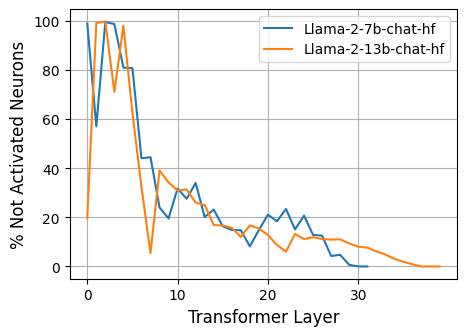

In [10]:
# Define subplots
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
for model_name in ["Llama-2-7b-chat-hf", "Llama-2-13b-chat-hf"]:
    layer_norms = json.load(open(f"{prof_dir}/{model_name}/layerwise_norms.json", "r"))

    layers, mlp_sparsities = [], []
    for layer, sparsity_dict in layer_norms.items():
        mlp_sparsity = sparsity_dict["mlp_sparsity"][str(mlp_threshold)]
        layers.append(layer)
        mlp_sparsities.append(mlp_sparsity * 100)
    
    ax.plot(layers, mlp_sparsities, label=model_name)
ax.set_xticks(np.arange(0, len(layers), 10))
ax.set_xlabel("Transformer Layer", fontsize=12)
ax.set_ylabel("% Not Activated Neurons", fontsize=12)
ax.legend()
ax.grid(True)
plt.show()

In [24]:
a = [torch.rand(50), torch.rand(50)]
torch.stack(a, axis=0).shape

torch.Size([2, 50])